# Homework #3

> 0. You'll need to use google colob for this homework -- `PyMC` is currently unavailable on UofT Jupyterhub
> 1. To get up to speed with using `PyMC` first review this weeks [coding demo](https://github.com/pointOfive/STA410_W24_StatisticalComputation/blob/main/Week3/STA410_W24_Week3_Demo_HMCwithPyMC.ipynb), and potentially the references at the end of the coding demo which were added as resources for competing this homework

0. Find a classification data set on [kaggle](https://www.kaggle.com)
1. Use `PyMC` to provide posterior inference for a Bayesian logistic regression analysis predicting the classification outcome with some of the other features of the data set
    - You should know that logistic regression defines the [probability](https://en.wikipedia.org/wiki/Logistic_regression#Model) of a [Bernoulli](https://en.wikipedia.org/wiki/Binomial_distribution#Probability_mass_function) outcome distribution using a linear model, but if you're unfamiliar with this model you'll be able to find many explanations online
    - A Bayesian logistic regression analysis simply needs the additional specification of priors on the coefficients of the linear model
    - **For half credit** you can try to use the "out of the box" [PyMC logistic regression functionality](https://www.pymc.io/projects/docs/en/v3/pymc-examples/examples/generalized_linear_models/GLM-logistic.html) [though I'm not 100% this is working for the current version of `PyMC`]
    - **For 3/4 credit**, rather than the above "out of the box" option, and instead specify your own priors for the $\beta$ coefficients, use a ***logit link function***, and the matrix multiplication form of logistic regression    
        - Here's a [simple linear regression](https://www.pymc.io/projects/docs/en/v3.11.4/pymc-examples/examples/generalized_linear_models/GLM-linear.html) example, but by dropping `intercept = Normal("Intercept", 0, sigma=20)` and adding the `shape` parameter for `x_coeff = pm.Normal("x", 0, sigma=20)` you can treat `x_coeff` as a vector and do multiple linear regression based on `pm.math.dot(X, x_coeff)` for any design matrix `X` in the manner described [here](https://discourse.pymc.io/t/matrix-multiplication-in-pymc3/111x4) (although they don't incorporate the intercept into the `x_coeff` vector in that example, which I would suggest you do unless you want to specify the intercept prior distinctly)     
            - A shorthand notation for  `pymc.math.dot(X, x_coeff)` is `X@x_coeff`, and for both of these `X` needs to be a `numpy.array` data type (and can't be a `pd.DataFrame` data type)
            - A `pd.DataFrame` data type would be a good way to read in the data, and then you can use `y = df.y.values` and `X = df[list_of_column_names]; X["intercept"]=1; X.values` to get the outcome and design matrix
            - Warnings that the log likelihood is `np.nan` are caused by the likelihood evaluating to `0` which would easily happen if, e.g., `pymc.math.invloit(X@x_coeff)` causes $\prod_{i=1}^n p_i^x (1-p_i)^{n-x}$ to evaluate to $0$
            - The `mu` parameter of the `pm.Normal` prior can be a vector of different values rather than being all `0`
    - **For full credit** use a ***probit link function*** instead of a ***logit link function***




2. Your posterior inference should be similar to that of the "Getting Started" material [here](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html#model-checking), which only requires a few simple function calls

3. There will be no MarkUs autochecks in the usual manner for this assignment; but, submit your notebook in the usual way on MarkUs except ensure all your figures have been rendered in your notebook upon submission as the evaluation of your work will be besed upon a visual inspection of your code and figure


In [73]:
# Required: only worth points when not completed, in which case, you'll lose points
Partner = "Woorim Kang"
# This cell will produce a runtime error until you assign a value to this variable
# Required: only worth points when not completed, in which case, you'll lose points
Problem_1 = "My partner and I contributed equally"
# This cell will produce a runtime error until you assign a value to this variable

In [75]:
# We can get some more information by turning on logging
import logging # dir(logging) for available functionality
_log = logging.getLogger("pymc")
#_log.setLevel(logging.NOTSET) # 0
_log.setLevel(logging.INFO) # 20
#_log.setLevel(logging.WARNING) # 30
#_log.setLevel(logging.ERROR) # 40

In [76]:
# apple quality classification dataset from kaggle: https://www.kaggle.com/datasets/nelgiriyewithana/apple-quality
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

# Read in the dataset
df = pd.read_csv("apple_quality.csv")  # Replace with the actual path to your dataset

# Drop the row with the non-numeric value
df.drop(4000, inplace=True)

df['Size'] = pd.to_numeric(df['Size'])
df['Weight'] = pd.to_numeric(df['Weight'])
df['Sweetness'] = pd.to_numeric(df['Sweetness'])
df['Crunchiness'] = pd.to_numeric(df['Crunchiness'])
df['Juiciness'] = pd.to_numeric(df['Juiciness'])
df['Ripeness'] = pd.to_numeric(df['Ripeness'])
df['Acidity'] = pd.to_numeric(df['Acidity'])
df.dropna(inplace=True)  # Drop rows with missing values

# Create outcome variable y and design matrix X
y = df['Quality'].values
X = df[['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness', 'Acidity']].values.astype(float)
X = np.column_stack((np.ones(X.shape[0]), X))  # Add intercept term



In [77]:
y_new = []
# changing string to numerical values ("bad" becomes 0 and "good" becomes 1)
for element in y:
    if element == "good":
        y_new.append(1)
    elif element == "bad":
        y_new.append(0)

y = np.array(y_new, dtype=np.int64)

In [78]:
# full credit
with pm.Model() as probit_model:
    x = pm.ConstantData("x", X, dims=("observation", "feature"))

    # Specify your own priors for coefficients
    beta = pm.Normal('beta', mu=0, sigma=1, shape=x.shape[1]) # coeffs for each column

    mu = pm.math.dot(x, beta)

    # Transform the linear combination using the inverse probit
    theta = pm.Deterministic("theta", pm.math.invprobit(mu), dims="observation")

    # Bernoulli likelihood for the observed data
    y_obs = pm.Bernoulli('y_obs', p=theta, observed=y, dims="observation")


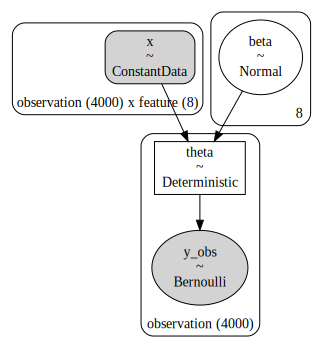

In [79]:
# visualize probit_model
pm.model_to_graphviz(probit_model)

In [80]:
SEED = [0, 1, 2, 3]
with probit_model:
    trace_probit = pm.sample(2000, chains=4, tune=1000, cores=2, random_seed=SEED, return_inferencedata=True)

INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 2 jobs)
INFO:pymc.sampling.mcmc:NUTS: [beta]


INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 144 seconds.


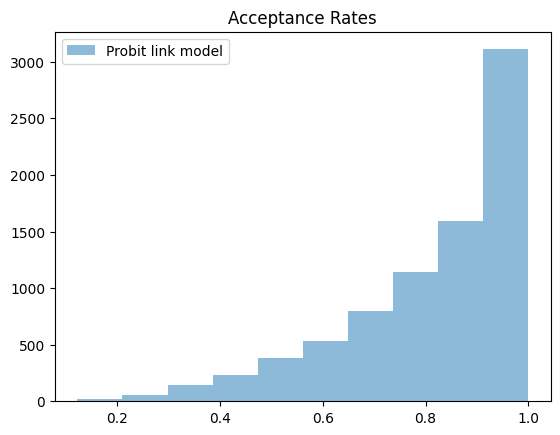

In [81]:
plt.hist(trace_probit.sample_stats.acceptance_rate.values.flatten(), alpha=0.5, label='Probit link model')
plt.title('Acceptance Rates'); plt.legend();

In [82]:
print("Effective Sample Sizes (function of Markov Chain autocorrelation dependency)")
pd.concat(
[pd.DataFrame({'Probit': pm.summary(trace_probit)[:1]['ess_bulk']}),

 pd.DataFrame({'Probit': pm.summary(trace_probit)[1:]['ess_bulk']})])

Effective Sample Sizes (function of Markov Chain autocorrelation dependency)


,Probit
beta[0],7305.0
beta[1],6432.0
beta[2],6704.0
beta[3],6515.0
beta[4],7939.0
...,...
theta[3995],10238.0
theta[3996],8248.0
theta[3997],9553.0
theta[3998],10848.0


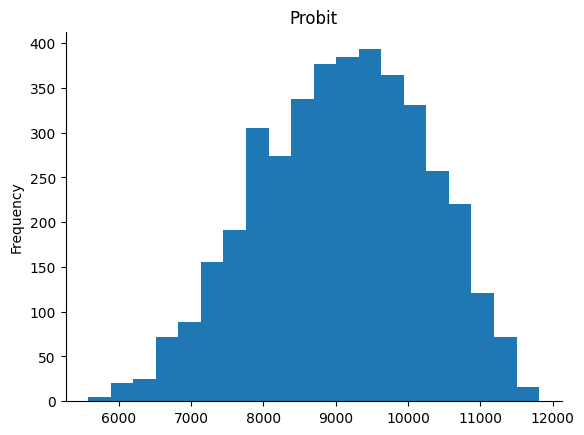

In [83]:
from matplotlib import pyplot as plt
_df_0['Probit'].plot(kind='hist', bins=20, title='Probit')
plt.gca().spines[['top', 'right',]].set_visible(False)

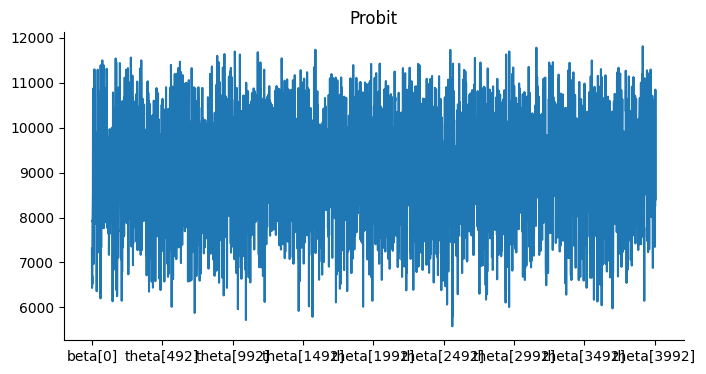

In [84]:
from matplotlib import pyplot as plt
_df_1['Probit'].plot(kind='line', figsize=(8, 4), title='Probit')
plt.gca().spines[['top', 'right']].set_visible(False)

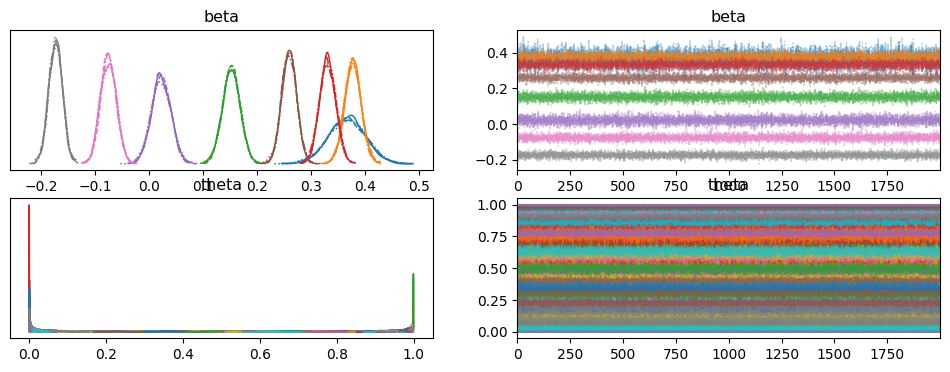

In [85]:
import arviz as az
az.plot_trace(trace_probit);
